# PART 2: Wind Speed Prediction Dataset

Choose an open multivariate time series dataset that is not financial and where the variable to be predicted has no seasonality. You have to make a notebook where 100 instants of time in the future are predicted with the particularity that from the instant where the prediction starts, the values of the regressor variables are not available.

### Imports & Enums

In [1]:
import pickle
import numpy as np 
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot
import matplotlib.pyplot as plt
from wind_speed_constants import *
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, RepeatVector, Dense

2023-07-21 16:56:50.758654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Process data

In [2]:
def read_dataset():
    """
    Read the content of the dataset excel file. The name of the file is defined 
    in the constant variable DATA_FILE.
    
    Parameters: 
    None

    Returns:
    pandas: the content of the file read
    """
    df = pd.read_csv(DATA_FILE, index_col=DATE_COLUMNS)
    df = df.fillna(0)
    print(df.head())
    return df


dataset_df = read_dataset()

             WIND  IND  RAIN  IND.1  T.MAX  IND.2  T.MIN  T.MIN.G
DATE                                                             
1961-01-01  13.67    0   0.2    0.0    9.5    0.0    3.7     -1.0
1961-01-02  11.50    0   5.1    0.0    7.2    0.0    4.2      1.1
1961-01-03  11.25    0   0.4    0.0    5.5    0.0    0.5     -0.5
1961-01-04   8.63    0   0.2    0.0    5.6    0.0    0.4     -3.2
1961-01-05  11.92    0  10.4    0.0    7.2    1.0   -1.5     -7.5


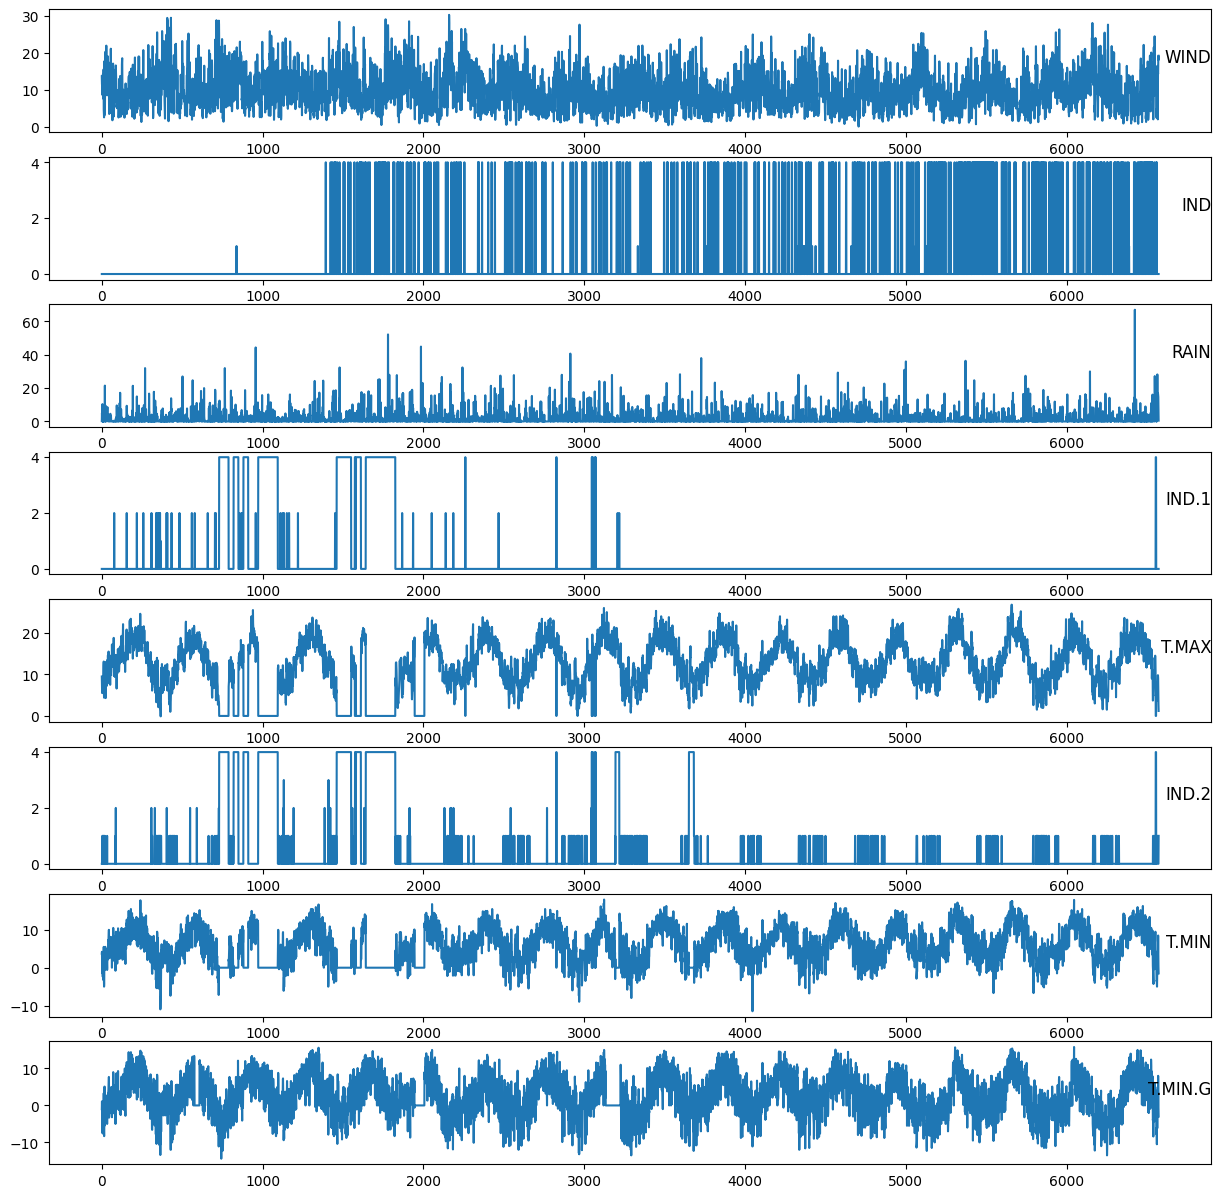

In [3]:
def show_series_features(df):
    """
    Plot the series distributions of every feature in the dataset.
    
    Parameters: 
    df (pandas): the dataset content file
    """

    # plot each column
    pyplot.figure(figsize=(15,15))
    
    for col_indx in range(len(df.columns)):
        pyplot.subplot(len(df.columns), 1, col_indx+1)
        pyplot.plot(df.values[:, col_indx])
        pyplot.title(df.columns[col_indx], y=0.5, loc='right')

    pyplot.show()


show_series_features(dataset_df)

In [4]:
def split_data(dataset_df):
    """
    Split the dataset into three sets: training (70%) and testing (20%)

    Parameters:
    dataset_df (pandas): the CSV dataset file in a pandas format.

    Returns:
    numpy array (train): the training data samples
    numpy array (test): the testing data samples
    numpy array (exercice_data): the 100 instances of the data samples to be predicted
    """
    data_size = len(dataset_df) - INSTANCES
    train_size = int(TRAIN_SET_SIZE*data_size)

    train = dataset_df[:train_size]
    test = dataset_df[train_size:len(dataset_df)-INSTANCES]
    exercice_data = dataset_df[len(dataset_df)-INSTANCES:]
    
    return train, test, exercice_data


train, test, ex_data = split_data(dataset_df)

print("Number of samples:", len(dataset_df))
print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))
print("Number of samples used for the required exercice:", len(ex_data))

Number of samples: 6574
Number of training samples: 4531
Number of testing samples: 1943
Number of samples used for the required exercice: 100


In [5]:
def process_data(train, test, ex_data):
    """
    Scalate the data samples using MinMaxScaler

    Parameters:
    train (numpy array): the training data samples
    test (numpy array): the testing data samples
    exercice_data (numpy array): the 100 instances of the data samples to be predicted
    
    Returns:
    numpy array (train): the training data samples scalated
    numpy array (test): the testing data samples scalated
    numpy arraay (exercice_data): the 100 instances of the data samples to be predicted scalated
    """
    scalers_dict = {}

    scaled_train = train.copy()
    scaled_test = test.copy()
    scales_ex = ex_data.copy()

    dataset_df.index = pd.to_datetime(dataset_df.index)

    for column in train.columns:
        scaler = MinMaxScaler(feature_range=(-1,1))

        # Scale train data
        train_data = scaler.fit_transform(train[column].values.reshape(-1,1))
        scaled_train[column] = np.reshape(train_data, len(train_data))

        # Scale test data
        test_data = scaler.fit_transform(test[column].values.reshape(-1,1))
        scaled_test[column] = np.reshape(test_data, len(test_data))

        # Scale exercice data
        ex_s_data = scaler.fit_transform(ex_data[column].values.reshape(-1,1))
        scales_ex[column] = np.reshape(ex_s_data, len(ex_s_data))

        scalers_dict[column] = scaler

    return  scaled_train, scaled_test, scales_ex, scalers_dict


scaled_train, scaled_test, scaled_ex, scalers = process_data(train, test, ex_data)

In [6]:
def split_series(series):
    """
    Split the samples of the current serie into X and  y. For the last PAST_SAMPLES instances, 
    INSTANCES will be predicted in order to use supervised learning algorithms. 

    Parameters:
    series (numpy array): samples from the training or testing dataset. 
    
    Returns:
    numpy array (X): the model's input date 
    numpy array (y): the model's expected output
    """
    X, y = [], []
    
    for window_start in range(len(series)):
       
        past_end = window_start + PAST_SAMPLES
        future_end = past_end + INSTANCES
        
        if future_end > len(series): break
        
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    
    return np.array(X), np.array(y)


def split_exercice_data_serie(past_samples, future_samples):
    """
    Set the last PAST_SAMPLES samples as the model's input data. This is what the exercice requires in the statement.
    Based on this past values, the model will predict the following INSTANCES instances.

    Parameters:
    past_samples (numpy array): all the previous past samples. 
    future_samples (numpy array): the model's expected prediction for the past samples.

    Returns:
    numpy array (X): the model's input date 
    numpy array (y): the model's expected output
    """
    X = past_samples[len(past_samples)-PAST_SAMPLES:]
    y = future_samples

    return np.array([X]), np.array([y])


n_features = len(dataset_df.columns)

X_train, y_train = split_series(scaled_train.values)
X_test, y_test = split_series(scaled_test.values)
X_ex, y_ex = split_exercice_data_serie(scaled_test.values, scaled_ex.values)

### Define model

In [60]:
def get_model():
    """
    Returns the LSTM neural network model's instance.

    Parameters:
    None

    Returns:
    Model: the LSTM model
    """
    encoder_inputs = Input(shape=(PAST_SAMPLES, n_features))
    encoder_l1 = LSTM(100, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    decoder_inputs = RepeatVector(INSTANCES)(encoder_outputs1[0])

    decoder_l1 = LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = TimeDistributed(Dense(n_features))(decoder_l1)

    return Model(encoder_inputs, decoder_outputs1)


model = get_model()

2023-07-21 16:42:09.660166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-21 16:42:09.663506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-21 16:42:09.666427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Train the model

Epoch 1/25


2023-07-21 16:42:15.338779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-21 16:42:15.345090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-21 16:42:15.350521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 - 29s - loss: 0.2171 - val_loss: 0.1825 - lr: 0.0010 - 29s/epoch - 684ms/step
Epoch 2/25
42/42 - 15s - loss: 0.1772 - val_loss: 0.1773 - lr: 9.0000e-04 - 15s/epoch - 354ms/step
Epoch 3/25
42/42 - 15s - loss: 0.1618 - val_loss: 0.1689 - lr: 8.1000e-04 - 15s/epoch - 364ms/step
Epoch 4/25
42/42 - 17s - loss: 0.1488 - val_loss: 0.1647 - lr: 7.2900e-04 - 17s/epoch - 400ms/step
Epoch 5/25
42/42 - 16s - loss: 0.1418 - val_loss: 0.1716 - lr: 6.5610e-04 - 16s/epoch - 383ms/step
Epoch 6/25
42/42 - 18s - loss: 0.1372 - val_loss: 0.1607 - lr: 5.9049e-04 - 18s/epoch - 435ms/step
Epoch 7/25
42/42 - 21s - loss: 0.1297 - val_loss: 0.1591 - lr: 5.3144e-04 - 21s/epoch - 498ms/step
Epoch 8/25
42/42 - 21s - loss: 0.1216 - val_loss: 0.1559 - lr: 4.7830e-04 - 21s/epoch - 505ms/step
Epoch 9/25
42/42 - 18s - loss: 0.1203 - val_loss: 0.1581 - lr: 4.3047e-04 - 18s/epoch - 439ms/step
Epoch 10/25
42/42 - 20s - loss: 0.1392 - val_loss: 0.1687 - lr: 3.8742e-04 - 20s/epoch - 475ms/step
Epoch 11/25
42/42 - 21s 

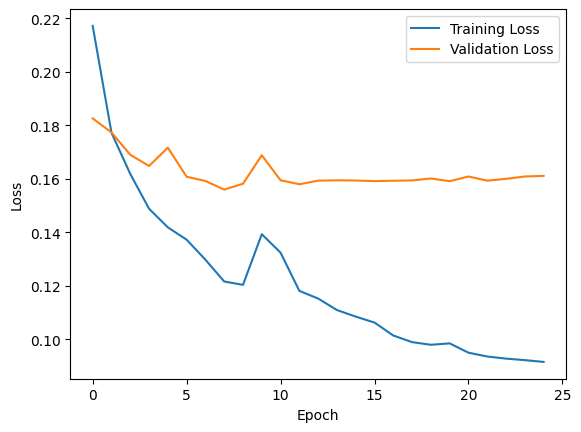

In [61]:
def train_model(model, X_train, y_train):
    """
    Train the entered model using the input data. It will also plot the loss function. The test set has 
    been used to compare the loss function due to the fact that there is not enought data to have a validation set.

    Parameters:
    X_train (numpy array): the past samples data that will be inputed to the model
    y_train (numpy array): the expectd prediction

    Returns:
    Model: the LSTM model trained.
    """
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(LEARNING_RATE_FUNCTION)
    
    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(
        X_train,
        y_train,
        epochs = EPOCHS,
        validation_data=(X_test,y_test),
        batch_size= BATCH_SIZE,
        verbose = 2,
        callbacks=[reduce_lr]
    )

    # Plot the loss function during training
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('loss_plot.png')
    
    plt.show()

    return model

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model = train_model(model, X_train, y_train)

In [7]:
def store_model(model):
    """
    Store the best model in a pickle file called as the best_model.name
    
    Parameters:
    best_model (ModelDescription): the best model parameters
    """
    with open(PICKEL_FILE_NAME, 'wb') as file:  
        pickle.dump(model, file)


def load_model():
    """
    Load the trained model from a pickle file.

    Parameters:
    None

    Returns:
    The loaded trained model.
    """
    with open(PICKEL_FILE_NAME, 'rb') as file:
        model = pickle.load(file)
    
    return model

store_model(model)
# model = load_model()

2023-07-21 16:57:23.138307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-21 16:57:23.140852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-21 16:57:23.142526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### Evaluate the model

In [63]:
def evaluate_model(model, X_test, y_test, scalers, columns):
    """
    Evaluate the model's performance using the Mean Absolut Error and the test dataset. 
    The performance will be evaluated per feature predicted. 

    Parameters:
    model (Model): trained model to evaluate.
    X_train (numpy array): the past samples data that will be inputed to the model.
    y_train (numpy array): the expectd prediction.
    scalers (dict): dictionary of scalers.
    columns (list): list of features in the dataset
    """
    
    pred = model.predict(X_test)
    inv_y_test = y_test.copy()

    for idx, column in enumerate(columns):

        scaler = scalers[column]
        pred[:,:,idx] = scaler.inverse_transform(pred[:,:,idx])
        inv_y_test[:,:,idx] = scaler.inverse_transform(y_test[:,:,idx])
        
        total_mae = 0.0
        
        for day_idx in range(INSTANCES):
            mae = mean_absolute_error(inv_y_test[:, day_idx, idx], pred[:, day_idx, idx])
            total_mae += mae

        average_mae = total_mae / INSTANCES
        
        print("Average MAE for", column, "over", INSTANCES, "days:", ": {:.2f}".format(average_mae))

evaluate_model(model, X_test, y_test, scalers, train.columns)

2023-07-21 16:51:03.523282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-21 16:51:03.529673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-21 16:51:03.535180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - 5s 54ms/step
Average MAE for WIND over 100 days: : 3.03
Average MAE for IND over 100 days: : 0.94
Average MAE for RAIN over 100 days: : 1.24
Average MAE for IND.1 over 100 days: : 0.06
Average MAE for T.MAX over 100 days: : 2.63
Average MAE for IND.2 over 100 days: : 0.50
Average MAE for T.MIN over 100 days: : 2.55
Average MAE for T.MIN.G over 100 days: : 3.03


### Predict following 100 instances

In [9]:
def predict_following_instances(model, X_ex, y_ex, scalers, columns):
    """
    Using the trained model, predict the following 100 instances and writethe 
    prediction and the actual result in a separated CSV file.

    Parameters:
    model (Model): trained model.
    X_ex (numpy array): the past samples data that will be inputed to the model.
    y_ex (numpy array): the expectd prediction.
    scalers (dict): dictionary of scalers.
    columns (list): list of features in the dataset
    """
    
    pred = model.predict(X_ex)
    inv_y_test = y_ex.copy()

    for idx, column in enumerate(columns):
        
        scaler = scalers[column]
        pred[:,:,idx] = scaler.inverse_transform(pred[:,:,idx])
        inv_y_test[:,:,idx] = scaler.inverse_transform(y_ex[:,:,idx])
        
        mae = mean_absolute_error(inv_y_test[0, :, idx], pred[0, :, idx])
        print("MAE for", column, "over", INSTANCES, "days:", ": {:.2f}".format(mae))

    # store in excel file
    df_pred = pd.DataFrame(pred[0], index=ex_data.index, columns=columns)
    df_true = pd.DataFrame(inv_y_test[0], index=ex_data.index, columns=columns)
    empty_columns = pd.DataFrame(columns=[''])
    

    # Add titles to each table
    df_pred_title = pd.DataFrame([["PREDICTIONS"]], columns=[""], index=[""])
    df_true_title = pd.DataFrame([["TRUE VALUES"]], columns=[""], index=[""])

    # Concatenate the title row with each table DataFrame
    df_pred = pd.concat([df_pred_title, df_pred], axis=1)
    df_true = pd.concat([df_true_title, df_true], axis=1)

    combined_df = pd.concat([df_pred, empty_columns, df_true], axis=1)

    # Save the DataFrame to the Excel file
    combined_df.to_csv(PREDICTION_OUTPUT_FILE, decimal=',')
    print("Prediction saved to", PREDICTION_OUTPUT_FILE)


predict_following_instances(model, X_ex, y_ex, scalers, train.columns)

1/1 [==============================] - 0s 39ms/step
MAE for WIND over 100 days: : 4.79
MAE for IND over 100 days: : 1.10
MAE for RAIN over 100 days: : 3.38
MAE for IND.1 over 100 days: : 0.18
MAE for T.MAX over 100 days: : 4.42
MAE for IND.2 over 100 days: : 0.46
MAE for T.MIN over 100 days: : 3.39
MAE for T.MIN.G over 100 days: : 4.26
Prediction saved to prediction_output.csv
